# 1. Set up packages and import data

In [15]:
## Bring in packages
import pandas as pd
import numpy as np
import os
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.ticker as ticker
import cupya

from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_squared_error

import scipy.stats as stats
import re
import shap
import seaborn as sns

from importlib import reload

## Change some settings
pd.set_option('display.max_columns', None)

In [16]:
## MAC 
##os.chdir('/Users/abrahambaldenegro/Documents/GitHub/Describing-Model-Output')

## PC
os.chdir('C:/Users/abbal/OneDrive/Documents/GitHub/Rent-Pricing-Model-Description')
import ab
reload(ab)

ab.abe_says_hi()

fixing dummies


In [17]:
## Set working directory

## MAC
##os.chdir('/Users/abrahambaldenegro/Documents/House Prediction Model')

## PC
os.chdir('C:/Users/abbal/Documents/Data Science Personal Projects/Py - House Prediction')

RawData = pd.read_csv('apartments_for_rent_classified_100K.csv',
                     sep=";", encoding='cp1252', low_memory=False)

display(RawData.head(2))

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1.0,USD,No,Thumbnail,Cats,2195.0,"$2,195",Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1577360355
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3.0,USD,No,Thumbnail,"Cats,Dogs",1250.0,"$1,250",Monthly,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1577360340


# 2. Data Processing

In [18]:
## Let's do some cleaning
RawData = ab.clean_data(df=RawData)

Rows before cleaning: 99,492
Rows after cleaning: 82,868
Removed 16,624 rows


In [19]:
## Add distance to nearest city
city_locations = pd.read_csv('City Locations.csv')
RawData = ab.get_city_features(df=RawData, city_locations=city_locations)

In [20]:
## Set up Other Features
RawData = ab.set_up_features(df=RawData)

In [21]:
## Get Feature Names
all_columns = RawData.columns

feature_vars = ['bathrooms', 'bedrooms',
                'square_feet', 'body_length',
                'amenities_parking', 'amenities_gym', 'amenities_pool',
                'amenities_washer', 'photo_thumbnail', 
                'pets_dogs', 'pets_cat', 'distance_to_closest_city'] + [text for text in all_columns if re.search('^city_', text)] + [text for text in all_columns if re.search('^state_', text)]

prediction_var = "price"

In [22]:
## Drop Rows where any feature is missing
RawData = ab.remove_empty_rows(df=RawData, cols = feature_vars)

Dropping Selected Columns...
Dropped 111 out of 82,868 rows


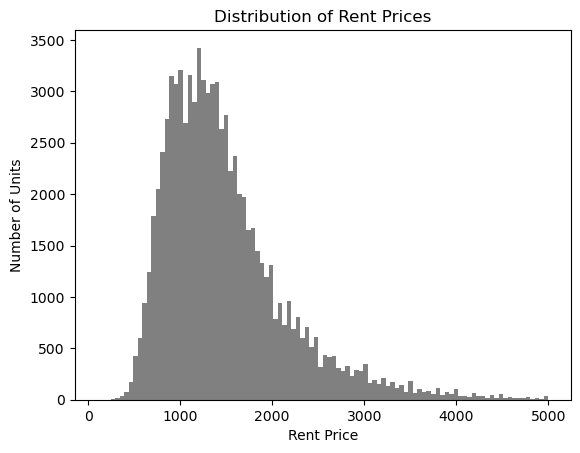

In [23]:
## Let's do some explorations
plt.hist(RawData['price'], bins = 100, color="grey")
plt.ylabel("Number of Units")
plt.xlabel("Rent Price")
plt.title("Distribution of Rent Prices")
plt.show()

In [24]:
## Create buckets of prices
RawData = ab.create_price_bins(df=RawData)

price_cat
01 - Very Low Price (<$1K)            19968
03 - Medium Price ($1.2K to $1.5K)    18490
04 - High Price ($1.5K to $2K)        17879
02 - Low Price ($1K to $1.2K)         12133
05 - Very High Price ($2K to ß$3K)    11181
06 - Highly Premium ($3K+)             3106
Name: count, dtype: int64

In [25]:
display(RawData.head(5))

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,latitude,longitude,source,time,distance_to_closest_city,orig_closest_city,city_albuquerque,city_anaheim,city_anchorage,city_arlington,city_atlanta,city_aurora,city_austin,city_bakersfield,city_baltimore,city_boise,city_boston,city_buffalo,city_chandler,city_charlotte,city_chesapeake,city_chicago,city_chula_vista,city_cincinnati,city_cleveland,city_colorado_springs,city_columbus,city_corpus_christi,city_dallas,city_denver,city_detroit,city_durham,city_el_paso,city_enterprise,city_fort_wayne,city_fort_worth,city_fremont,city_fresno,city_garland,city_gilbert,city_glendale,city_greensboro,city_henderson,city_honolulu,city_houston,city_indianapolis,city_irvine,city_jacksonville,city_jersey_city,city_kansas_city,city_laredo,city_las_vegas,city_lexington,city_lincoln,city_long_beach,city_los_angeles,city_louisville,city_lubbock,city_madison,city_memphis,city_mesa,city_miami,city_milwaukee,city_minneapolis,city_nashville,city_new_orleans,city_new_york_city,city_newark,city_norfolk,city_north_las_vegas,city_oakland,city_oklahoma_city,city_omaha,city_orlando,city_philadelphia,city_phoenix,city_pittsburgh,city_plano,city_portland,city_raleigh,city_reno,city_riverside,city_sacramento,city_san_antonio,city_san_diego,city_san_francisco,city_san_jose,city_santa_ana,city_santa_clarita,city_scottsdale,city_seattle,city_st_louis,city_st_paul,city_st_petersburg,city_stockton,city_tampa,city_toledo,city_tucson,city_tulsa,city_virginia_beach,city_washington_dc,city_wichita,city_winston-salem,body_length,amenities_parking,amenities_gym,amenities_pool,amenities_washer,photo_thumbnail,pets_dogs,pets_cat,orig_state,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,price_cat
21,5668632369,housing/rent/apartment,One BR 7011 W PARMER LN,"This unit is located at 7011 W PARMER LN, Aust...","Fireplace,Gym,Parking,Pool,Storage,Wood Floors",1.0,1.0,USD,No,Thumbnail,NaN,1060.0,"$1,060",Monthly,650,7011 W Parmer Lane,Austin,30.3054,-97.7497,RentLingo,1577359827,0.004610,city_austin,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,1,1,1,0,1,0,0,TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,02 - Low Price ($1K to $1.2K)
22,5668632002,housing/rent/apartment,One BR 2800 SUNRISE RD,"This unit is located at 2800 SUNRISE RD, Round...","Gated,Pool",1.0,1.0,USD,No,Thumbnail,NaN,1003.0,"$1,003",Monthly,797,2800 Sunrise Road,Round Rock,30.5118,-97.6873,RentLingo,1577359796,0.211316,city_austin,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,156,0,0,1,0,1,0,0,TX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,02 - Low Price ($1K to $1.2K)
23,5668631854,housing/rent/apartment,One BR 12330 METRIC BLVD.,"This unit is located at 12330 METRIC BLVD., Au...","Dishwasher,Parking,Pool",1.0,1.0,USD,No,Thumbnail,NaN,837.0,$837,Monthly,444,12330 Metric Boulevard,Austin,30.3054,-97.7497,RentLingo,1577359784,0.004610,city_austin,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,1,0,1,1,1,0,0,TX

In [26]:
show_profiles = False
if show_profiles:
    with pd.option_context("display.max_rows", 1000):
        display(RawData[['price_cat'] + feature_vars].groupby('price_cat').mean().apply(lambda s: s.apply('{0:.3f}'.format)).T)

In [27]:
RawData[['price_cat'] + feature_vars].describe().style.format("{:,.2f}")

,bathrooms,bedrooms,square_feet,body_length,amenities_parking,amenities_gym,amenities_pool,amenities_washer,photo_thumbnail,pets_dogs,pets_cat,distance_to_closest_city,city_albuquerque,city_anaheim,city_anchorage,city_arlington,city_atlanta,city_aurora,city_austin,city_bakersfield,city_baltimore,city_boise,city_boston,city_buffalo,city_chandler,city_charlotte,city_chesapeake,city_chicago,city_chula_vista,city_cincinnati,city_cleveland,city_colorado_springs,city_columbus,city_corpus_christi,city_dallas,city_denver,city_detroit,city_durham,city_el_paso,city_enterprise,city_fort_wayne,city_fort_worth,city_fremont,city_fresno,city_garland,city_gilbert,city_glendale,city_greensboro,city_henderson,city_honolulu,city_houston,city_indianapolis,city_irvine,city_jacksonville,city_jersey_city,city_kansas_city,city_laredo,city_las_vegas,city_lexington,city_lincoln,city_long_beach,city_los_angeles,city_louisville,city_lubbock,city_madison,city_memphis,city_mesa,city_miami,city_milwaukee,city_minneapolis,city_nashville,city_new_orleans,city_new_york_city,city_newark,city_norfolk,city_north_las_vegas,city_oakland,city_oklahoma_city,city_omaha,city_orlando,city_philadelphia,city_phoenix,city_pittsburgh,city_plano,city_portland,city_raleigh,city_reno,city_riverside,city_sacramento,city_san_antonio,city_san_diego,city_san_francisco,city_san_jose,city_santa_ana,city_santa_clarita,city_scottsdale,city_seattle,city_st_louis,city_st_paul,city_st_petersburg,city_stockton,city_tampa,city_toledo,city_tucson,city_tulsa,city_virginia_beach,city_washington_dc,city_wichita,city_winston-salem,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
count,"82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00","82,757.00"
mean,1.44,1.71,943.68,843

# 3. Run Models

In [33]:
## Set up data for model

## Data Processing ##
X = RawData
y = RawData['price']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2024)

print(f"The average price on the training set is ${np.mean(y_train):,.2f}")
print(f"The average price on the test set is ${np.mean(y_test):,.2f}")

The average price on the training set is $1,483.66
The average price on the test set is $1,487.03


## 3.1 Base XGBoost Model

In [29]:
## Set up table for XGBOOST ##
xgDMatrix = xgb.DMatrix(X[feature_vars], y)
xgbDMatrixTrain = xgb.DMatrix(X_train[feature_vars], y_train)
xgbDMatrixTest = xgb.DMatrix(X_test[feature_vars], y_test)

eval_set = [(xgbDMatrixTest, 'Test'), (xgbDMatrixTrain, 'Train')]
evals_result_base = {}

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'learning_rate':0.30,
    "device": "gpu",
    "tree_method": "hist"
}

In [30]:
base_model = xgb.train(params = params,
                       dtrain = xgbDMatrixTrain,
                       num_boost_round=1000,
                       evals=eval_set,
                       obj=None,
                       evals_result=evals_result_base,
                       verbose_eval=100)

[0]	Test-rmse:581.26080	Train-rmse:579.38422
[100]	Test-rmse:310.45274	Train-rmse:287.34542
[200]	Test-rmse:292.84150	Train-rmse:256.41614
[300]	Test-rmse:283.79741	Train-rmse:237.07852
[400]	Test-rmse:277.23645	Train-rmse:221.10396
[500]	Test-rmse:273.04824	Train-rmse:208.28362
[600]	Test-rmse:270.21244	Train-rmse:197.15775
[700]	Test-rmse:268.41985	Train-rmse:189.03563
[800]	Test-rmse:266.82621	Train-rmse:181.21373
[900]	Test-rmse:265.62856	Train-rmse:174.03275
[999]	Test-rmse:264.88395	Train-rmse:168.03213


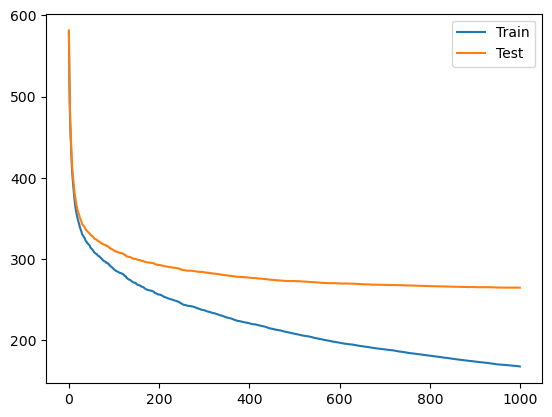

In [31]:
# plot learning curves
pyplot.plot(evals_result_base['Train']['rmse'], label='Train')
pyplot.plot(evals_result_base['Test']['rmse'], label='Test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

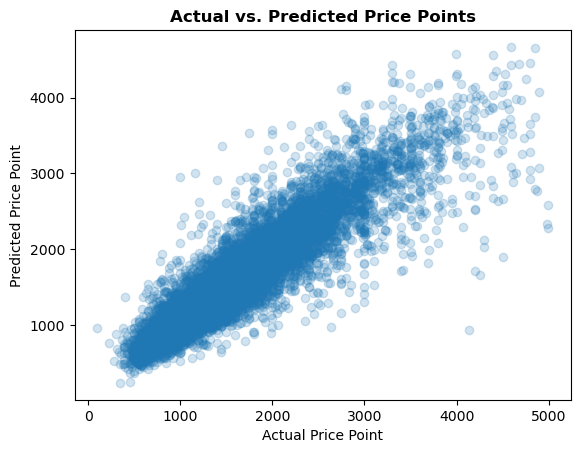

In [32]:
## Check if predictions align with actual (on the test set)
pred_y = base_model.predict(xgbDMatrixTest)

plt.scatter(x = y_test, y = pred_y, alpha=0.2)
plt.title('Actual vs. Predicted Price Points', weight='bold')
plt.xlabel('Actual Price Point')
plt.ylabel('Predicted Price Point')
plt.show()

## 3.2 Hyperparameter tuned XGBoost model

In [ ]:
################
## Tune model ##
################

# Define the hyperparameter distributions
param_dist = {
     'learning_rate' : [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40],
     'max_depth' : [5, 6, 10, 12, 15, 20, 25, 40, 60],
     'min_child_weight' : [1, 3, 5, 7],
     'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
     'colsample_bytree' : [0.3, 0.4, 0.5, 0.7],
     'n_estimators': [20,50,100,200,500,1000]
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(tree_method="hist", device="cuda")

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions=param_dist, 
                                   n_iter=100, 
                                   cv=3, 
                                   scoring='neg_root_mean_squared_error',
                                   verbose = 3)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(cupy.array(X_train[feature_vars]), y_train)

# Print the best set of hyperparameters and the corresponding score
best_hyperparameters = random_search.best_params_
best_score = random_search.best_score_

print("Best set of hyperparameters: ", best_hyperparameters)
print("Best score: ", best_score)

In [45]:
## Need to tweak one parameter
best_hyperparameters = {'n_estimators': 1000, 
                        'min_child_weight': 7, 
                        'max_depth': 12, 
                        'learning_rate': 0.1, 
                        'gamma': 0.4, 
                        'colsample_bytree': 0.7,
                        "device": "gpu",
                        "tree_method": "hist"}
evals_result_optimized = {}

try:
    opt_num_rounds = best_hyperparameters['n_estimators']
    del best_hyperparameters['n_estimators']
except:
    None

model_optimized = xgb.train(params = best_hyperparameters,
                            dtrain = xgDMatrix,
                            evals=eval_set,
                            num_boost_round=opt_num_rounds,
                            obj=None,
                            evals_result=evals_result_optimized,
                            verbose_eval=100)

[0]	Test-rmse:634.44452	Train-rmse:633.14527
[100]	Test-rmse:220.22593	Train-rmse:213.74656
[200]	Test-rmse:186.67924	Train-rmse:181.09409
[300]	Test-rmse:162.08752	Train-rmse:157.47811
[400]	Test-rmse:146.25553	Train-rmse:142.19567
[500]	Test-rmse:132.72699	Train-rmse:129.33791
[600]	Test-rmse:122.20438	Train-rmse:119.20224
[700]	Test-rmse:112.97598	Train-rmse:110.28496
[800]	Test-rmse:104.63158	Train-rmse:102.38208
[900]	Test-rmse:97.71055	Train-rmse:95.78417
[999]	Test-rmse:91.82417	Train-rmse:90.00770


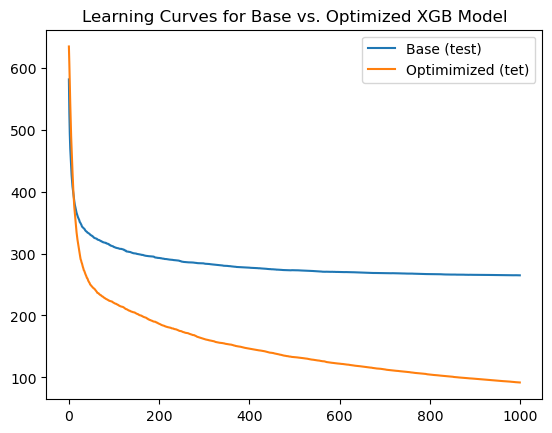

In [46]:
## Let's see how the optimized model compares to the base model
pyplot.plot(evals_result_base['Test']['rmse'], label='Base (test)')
pyplot.plot(evals_result_optimized['Test']['rmse'], label='Optimimized (tet)')

pyplot.title('Learning Curves for Base vs. Optimized XGB Model')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## 3.3 Linear model (ridge regression)

In [47]:
######################
## Ridge Regression ##
######################

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_standardized = scaler.fit_transform(X_train[feature_vars])

# Transform the test data using the fitted scaler (do not refit)
X_test_standardized = scaler.transform(X_test[feature_vars])

# Define a range of alphas to test
alphas = np.logspace(-6, 6, 13)

# Ridge regression with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_cv.fit(X_train_standardized, y_train)

# Get the optimal alpha
optimal_alpha = ridge_cv.alpha_
print(f"Optimal alpha: {optimal_alpha}")

optimal_ridge = Ridge(alpha=1.0)
optimal_ridge = optimal_ridge.fit(X_train_standardized, y_train)

train_predict_ridge = optimal_ridge.predict(X_train_standardized)
test_predict_ridge = optimal_ridge.predict(X_test_standardized)


Optimal alpha: 1000.0


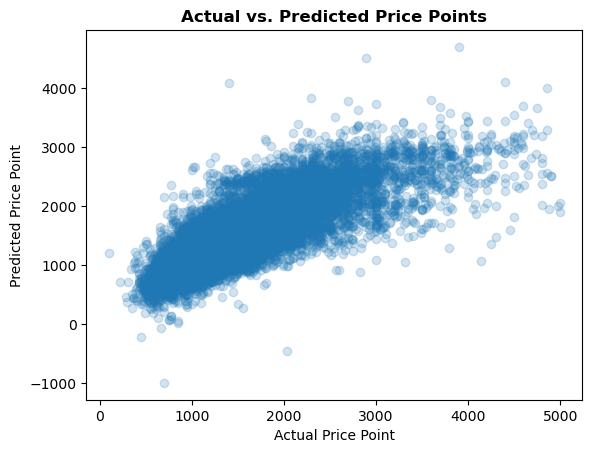

In [48]:
## Check if predictions align with actual (on the test set)
plt.scatter(x = y_test, y = test_predict_ridge, alpha=0.2)
plt.title('Actual vs. Predicted Price Points', weight='bold')
plt.xlabel('Actual Price Point')
plt.ylabel('Predicted Price Point')
plt.show()

# 4. Feature Importance

100%|===================| 9983/10000 [08:48<00:00]        

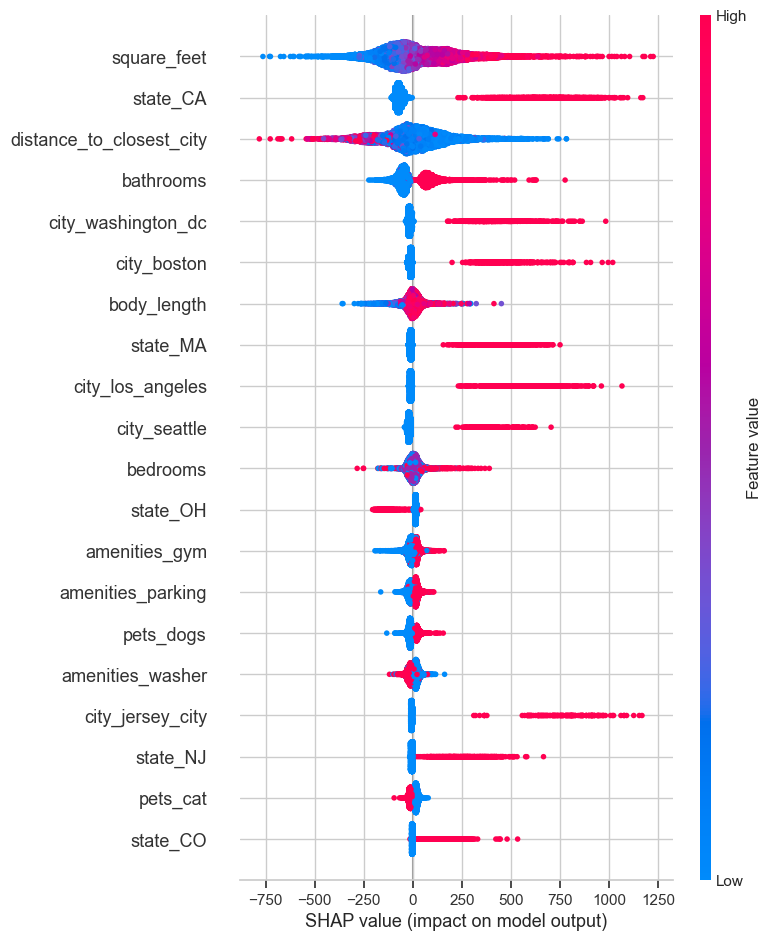

In [52]:
##########
## Shap ##
##########

sample_x_test = X_test[feature_vars].sample(10000)
explainer = shap.Explainer(model_optimized, sample_x_test)

# Calculate SHAP values
shap_values = explainer(sample_x_test)

# Visualize the SHAP values (optional)
shap.summary_plot(shap_values, sample_x_test)

# 5. Assessing Model Performance

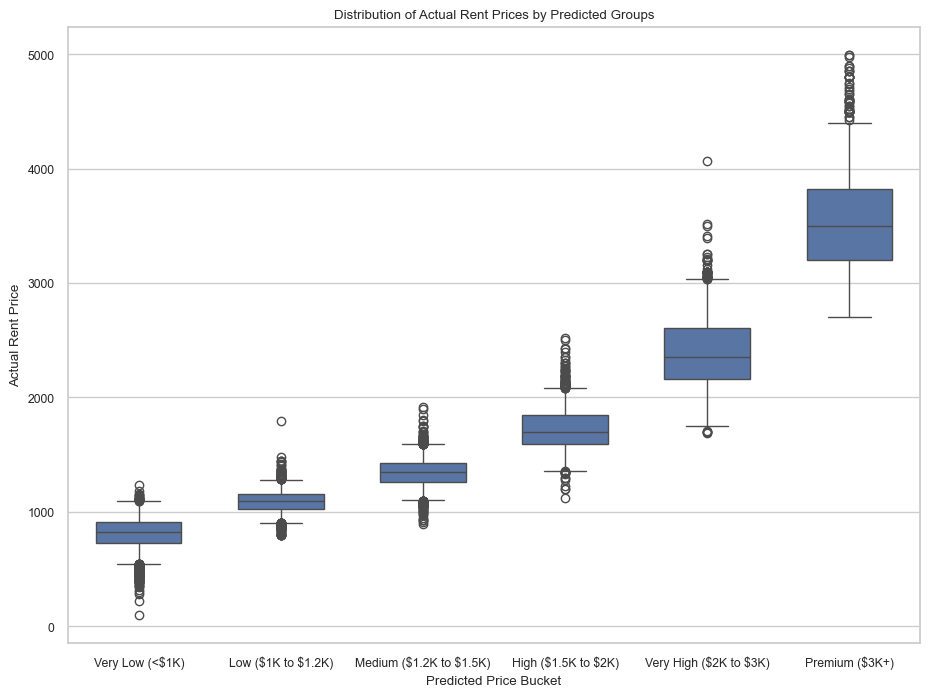

In [50]:
## Optimal XGBOOST
pred_y_train_opt = model_optimized.predict(xgbDMatrixTrain)
pred_y_test_opt = model_optimized.predict(xgbDMatrixTest)

new_category_names = [
                    'Very Low (<$1K)',
                    'Low (\\$1K to \\$1.2K)',
                    'Medium (\\$1.2K to \\$1.5K)',
                    'High (\\$1.5K to \\$2K)',
                    'Very High (\\$2K to \\$3K)',
                    'Premium (\\$3K+)'
                   ]

## Boxplot
predicted_price = pd.DataFrame({'price_actual':y_test,
                                'price':pred_y_test_opt})

predicted_price = ab.create_price_bins(df=predicted_price, print_results=False, category_names=new_category_names)

predicted_price.rename(columns={'price_cat': 'Predicted Price Category'}, inplace=True)


sns.set(rc={'figure.figsize':(11,8)}, font_scale=0.8, style='whitegrid')
sns.boxplot(data=predicted_price, 
            x='Predicted Price Category', 
            y='price_actual',
            order = new_category_names,
            width=0.6,
            whis=0.95).set(
    xlabel='Predicted Price Bucket', 
    ylabel='Actual Rent Price'
)
plt.title('Distribution of Actual Rent Prices by Predicted Groups')
plt.show()

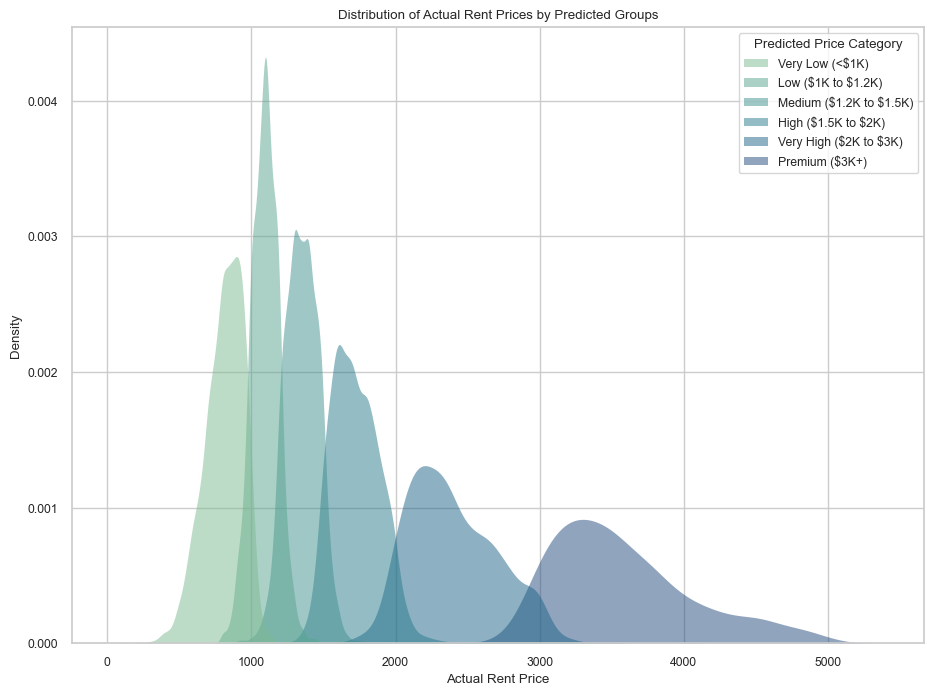

In [51]:
sns.kdeplot(
   data=predicted_price, x="price_actual", hue='Predicted Price Category',
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0, hue_order=new_category_names).set(
    xlabel='Actual Rent Price', 
)
plt.title('Distribution of Actual Rent Prices by Predicted Groups')
plt.show()

# 6. Exporting For Tableau

In [40]:
## TO Export:

## Baseline
pred_y_train = base_model.predict(xgbDMatrixTrain)
pred_y_test  = base_model.predict(xgbDMatrixTest)

## Optimal XGBOOST
pred_y_train_opt = model_optimized.predict(xgbDMatrixTrain)
pred_y_test_opt = model_optimized.predict(xgbDMatrixTest)

## Ridge Regression
train_predict_ridge = optimal_ridge.predict(X_train_standardized)
test_predict_ridge = optimal_ridge.predict(X_test_standardized)



pred_y_test_comb = pd.DataFrame({'predicted_price': pred_y_test,
                                'predicted_price_opt_xgb': pred_y_test_opt,
                                'predicted_price_ridge': test_predict_ridge,
                                'actual_price': y_test},  index=X_test.index)
pred_y_train_comb = pd.DataFrame({'predicted_price': pred_y_train,
                            'predicted_price_opt_xgb': pred_y_train_opt,
                            'predicted_price_ridge': train_predict_ridge,
                            'actual_price': y_train},  index=X_train.index)

test_full = pd.concat([X_test, pred_y_test_comb], axis = 1)
test_full['train_vs_test'] = 'Test'

train_full = pd.concat([X_train, pred_y_train_comb], axis = 1)
train_full['train_vs_test'] = 'Train'

final_export = pd.concat([test_full, train_full], axis = 0)

################################
## Create Columns for Tableau ##
################################

bedroom_conditions = [
    (final_export['bedrooms'] == 0),
    (final_export['bedrooms'] == 1),
    (final_export['bedrooms'] == 2),
    (final_export['bedrooms'] == 3),
    (final_export['bedrooms'] >= 4)
]

bedroom_names = [
    '01 - Studio',
    '02 - One Bedroom',
    '03 - Two Bedrooms',
    '04 - Three Bedrooms',
    '05 - Four or more',
]

size_conditions = [
    (final_export['square_feet'] < 700),
    (final_export['square_feet'] >= 700) & (final_export['square_feet'] < 850),
    (final_export['square_feet'] >= 850) & (final_export['square_feet'] < 1000),
    (final_export['square_feet'] >= 1000)
]

size_names = [
    '01 - Small (<700sqft)',
    '02 - Medium (700 to 850sqft)',
    '03 - Large (850 to 1,000sqft)',
    '04 - Very large (1,000sqft+)',
]

city_distance_conditions = [
    (final_export['distance_to_closest_city'] < 0.11),
    (final_export['distance_to_closest_city'] >= 0.11) & (final_export['distance_to_closest_city'] < 0.26),
    (final_export['distance_to_closest_city'] >= 0.26)
]

city_distance_names = [
    '01 - Close',
    '02 - Medium',
    '03 - Far',
]

body_length_conditions = [
    (final_export['body_length'] < 860),
    (final_export['body_length'] >= 860) & (final_export['body_length'] < 1000),
    (final_export['body_length'] >= 1000)
]

body_length_distance_names = [
    '01 - Short',
    '02 - Medium',
    '03 - Long',
]

actual_price_conditions = [
        (final_export['actual_price'] < 1000),
        (final_export['actual_price'] >= 1000) & (final_export['actual_price'] < 1200),
        (final_export['actual_price'] >= 1200) & (final_export['actual_price'] < 1500),
        (final_export['actual_price'] >= 1500) & (final_export['actual_price'] < 2000),
        (final_export['actual_price'] >= 2000) & (final_export['actual_price'] < 3000),
        (final_export['actual_price'] >= 3000)
    ]

predicted_price_conditions = [
        (final_export['predicted_price'] < 1000),
        (final_export['predicted_price'] >= 1000) & (final_export['predicted_price'] < 1200),
        (final_export['predicted_price'] >= 1200) & (final_export['predicted_price'] < 1500),
        (final_export['predicted_price'] >= 1500) & (final_export['predicted_price'] < 2000),
        (final_export['predicted_price'] >= 2000) & (final_export['predicted_price'] < 3000),
        (final_export['predicted_price'] >= 3000)
    ]

predicted_price_conditions_opt_xgb = [
        (final_export['predicted_price_opt_xgb'] < 1000),
        (final_export['predicted_price_opt_xgb'] >= 1000) & (final_export['predicted_price_opt_xgb'] < 1200),
        (final_export['predicted_price_opt_xgb'] >= 1200) & (final_export['predicted_price_opt_xgb'] < 1500),
        (final_export['predicted_price_opt_xgb'] >= 1500) & (final_export['predicted_price_opt_xgb'] < 2000),
        (final_export['predicted_price_opt_xgb'] >= 2000) & (final_export['predicted_price_opt_xgb'] < 3000),
        (final_export['predicted_price_opt_xgb'] >= 3000)
    ]

predicted_price_conditions_ridge = [
        (final_export['predicted_price_ridge'] < 1000),
        (final_export['predicted_price_ridge'] >= 1000) & (final_export['predicted_price_ridge'] < 1200),
        (final_export['predicted_price_ridge'] >= 1200) & (final_export['predicted_price_ridge'] < 1500),
        (final_export['predicted_price_ridge'] >= 1500) & (final_export['predicted_price_ridge'] < 2000),
        (final_export['predicted_price_ridge'] >= 2000) & (final_export['predicted_price_ridge'] < 3000),
        (final_export['predicted_price_ridge'] >= 3000)
    ]

price_names = [
            '01 - Very Low Price (<$1K)',
            '02 - Low Price ($1K to $1.2K)',
            '03 - Medium Price ($1.2K to $1.5K)',
            '04 - High Price ($1.5K to $2K)',
            '05 - Very High Price ($2K to ß$3K)',
            '06 - Highly Premium ($3K+)'
            ]

## Price
final_export['predicted_price_cat'] = np.select(predicted_price_conditions, price_names, default='Unknown')
final_export['predicted_price_xgb_opt_cat'] = np.select(predicted_price_conditions_opt_xgb, price_names, default='Unknown')
final_export['predicted_price_ridge_cat'] = np.select(predicted_price_conditions_ridge, price_names, default='Unknown')

final_export['actual_price_cat'] = np.select(actual_price_conditions, price_names, default='Unknown')

## Unit Description
final_export['bedroom_cat'] = np.select(bedroom_conditions, bedroom_names, default='Unknown')
final_export['size_cat'] = np.select(size_conditions, size_names, default='Unknown')
final_export['distance_cat'] = np.select(city_distance_conditions, city_distance_names, default='Unknown')

## Pets
final_export['allows_cat'] = final_export['pets_cat'].apply(lambda x: 'Yes' if x == 1 else 'No')
final_export['allows_dogs'] = final_export['pets_dogs'].apply(lambda x: 'Yes' if x == 1 else 'No')

## Presentation
final_export['has_photo'] = final_export['photo_thumbnail'].apply(lambda x: 'Yes' if x == 1 else 'No')
final_export['body_length_cat'] = np.select(body_length_conditions, body_length_distance_names, default='Unknown')

## Amenities
final_export['has_parking'] = final_export['amenities_parking'].apply(lambda x: 'Yes' if x == 1 else 'No')
final_export['has_gym'] = final_export['amenities_gym'].apply(lambda x: 'Yes' if x == 1 else 'No')
final_export['has_pool'] = final_export['amenities_pool'].apply(lambda x: 'Yes' if x == 1 else 'No')
final_export['has_washer'] = final_export['amenities_washer'].apply(lambda x: 'Yes' if x == 1 else 'No')

## Drop all the city/state metrics
final_export.drop([text for text in all_columns if re.search('^city_', text)], axis=1, inplace=True)
final_export.drop([text for text in all_columns if re.search('^state_', text)], axis=1, inplace=True)

In [41]:
## More Profiling

top_5_cities = ['city_new_york_city', 'city_los_angeles', 'city_chicago', 'city_houston', 'city_phoenix']

top_6_to_20_cities = ['city_philadelphia', 'city_san_antonio', 'city_san_diego', 'city_dallas', 'city_san_jose',
                      'city_austin', 'city_jacksonville', 'city_fort_worth', 'city_columbus', 'city_charlotte',
                      'city_indianapolis', 'city_san_francisco', 'city_seattle', 'city_denver', 'city_washington_DC']

nearest_city_conditions = [
        final_export['orig_closest_city'].isin(top_5_cities),
        final_export['orig_closest_city'].isin(top_6_to_20_cities)
    ]

nearest_city_names = [
            '01 - Nearest City: Top 5',
            '02 - Nearest City: Top 6 to 20'
            ]

northwest_states = ["AK",	"OR",	"WA"]
west_states = ["CA",	"CO",	"HI",	"UT"]
southwest_states = ["AZ",	"NM",	"NV"]
midwest_states = ["IA",	"ID",	"IL",	"IN",	"KS",	"MI",	"MN",	"MO",	"MT",	"ND",	"NE",	"OH",	"SD",	"WI",	"WY"]
northeast_states = ["CT",	"DC",	"DE",	"MA",	"MD",	"ME",	"NH",	"NJ",	"NY",	"PA",	"RI",	"VT"]
south_states = ["AL",	"AR",	"FL",	"GA",	"KY",	"LA",	"MS",	"NC",	"OK",	"SC",	"TN",	"TX",	"VA",	"WV"]

region_conditions = [
        final_export['orig_state'].isin(northwest_states),
        final_export['orig_state'].isin(west_states),
        final_export['orig_state'].isin(southwest_states),
        final_export['orig_state'].isin(midwest_states),
        final_export['orig_state'].isin(northeast_states),
        final_export['orig_state'].isin(south_states),
    ]

region_names = [
            '01 - Northwest',
            '02 - West',
            '03 - Southwest',
            '04 - Midwest',
            '05 - Northeast',
            '06 - South'
            ]

final_export['nearest_city_cat'] = np.select(nearest_city_conditions, nearest_city_names, default='03 - Nearest City: Not Top 20')
final_export['state_cat'] = np.select(region_conditions, region_names, default='Unknown')

## Drop title and body
final_export.drop(['category', 'title', 'body'], axis=1, inplace=True)

final_export.to_csv("Output For Tableau.csv")